# Improving Multimodal RAG with Inference Scaling
*Using IBM Granite, Docling, and Langchain*

Welcome to this Granite recipe. In this recipe, you'll learn how to harness the power of inference scaling to improve the multimodal RAG pipeline created in a [previous recipe](https://github.com/ibm-granite-community/granite-snack-cookbook/blob/main/recipes/RAG/Granite_Multimodal_RAG.ipynb).

## Introduction to Inference Scaling

Inference scaling is a technique that allocates more computational resources during test time to achieve better performance. Unlike training-time scaling (using larger models), inference scaling leverages additional computation when generating responses without changing the underlying model. This approach can lead to almost linear improvements in performance when properly implemented.

This tutorial will guide you through the following processes:

- **Document preprocessing:** You will learn how to handle documents from various sources, parse and transform them into usable formats and store them in vector databases by using Docling. You will use a Granite MLLM to generate image descriptions of images in the documents.
- **RAG:** Understand how to connect LLMs such as Granite with external knowledge bases to enhance query responses and generate valuable insights.
- **Implementing DRAG and IterDRAG:** Apply the inference scaling techniques from the research paper to significantly improve RAG performance when working with long context.
- **LangChain for workflow integration:** Discover how to use LangChain to streamline and orchestrate document processing and retrieval workflows, enabling seamless interaction between different components of the system.

And uses three cutting-edge technologies:

1. **[Docling](https://docling-project.github.io/docling/):** An open-source toolkit used to parse and convert documents.
2. **[Granite](https://www.ibm.com/granite/docs/models/granite/):** A state-of-the-art family of LLMs that provide robust natural language capabilities and a vision language model that provides image to text generation.
3. **[LangChain](https://github.com/langchain-ai/langchain):** A powerful framework used to build applications powered by language models, designed to simplify complex workflows and integrate external tools seamlessly.

By the end of this recipe, you will accomplish the following:
- Gain proficiency in document preprocessing, chunking and image understanding.
- Integrate vector databases to enhance retrieval capabilities.
- Implement DRAG and IterDRAG to perform efficient and accurate data retrieval with inference scaling.
- Experience firsthand how scaling inference compute can lead to almost linear improvements in RAG performance.

This recipe is designed for AI developers, researchers and enthusiasts looking to enhance their knowledge of document management and advanced natural language processing (NLP) techniques.

## Understanding Long-Context Challenges

Traditional language models struggle with long contexts for several reasons:
- Attention mechanisms scale quadratically with input length
- Difficulty in locating relevant information in very long sequences
- Challenges in preserving coherence across distant parts of the input
- Increased computational demands for processing long sequences

The techniques in this tutorial address these challenges through strategic allocation of inference computation.

## Inference Scaling Methods: DRAG and IterDRAG
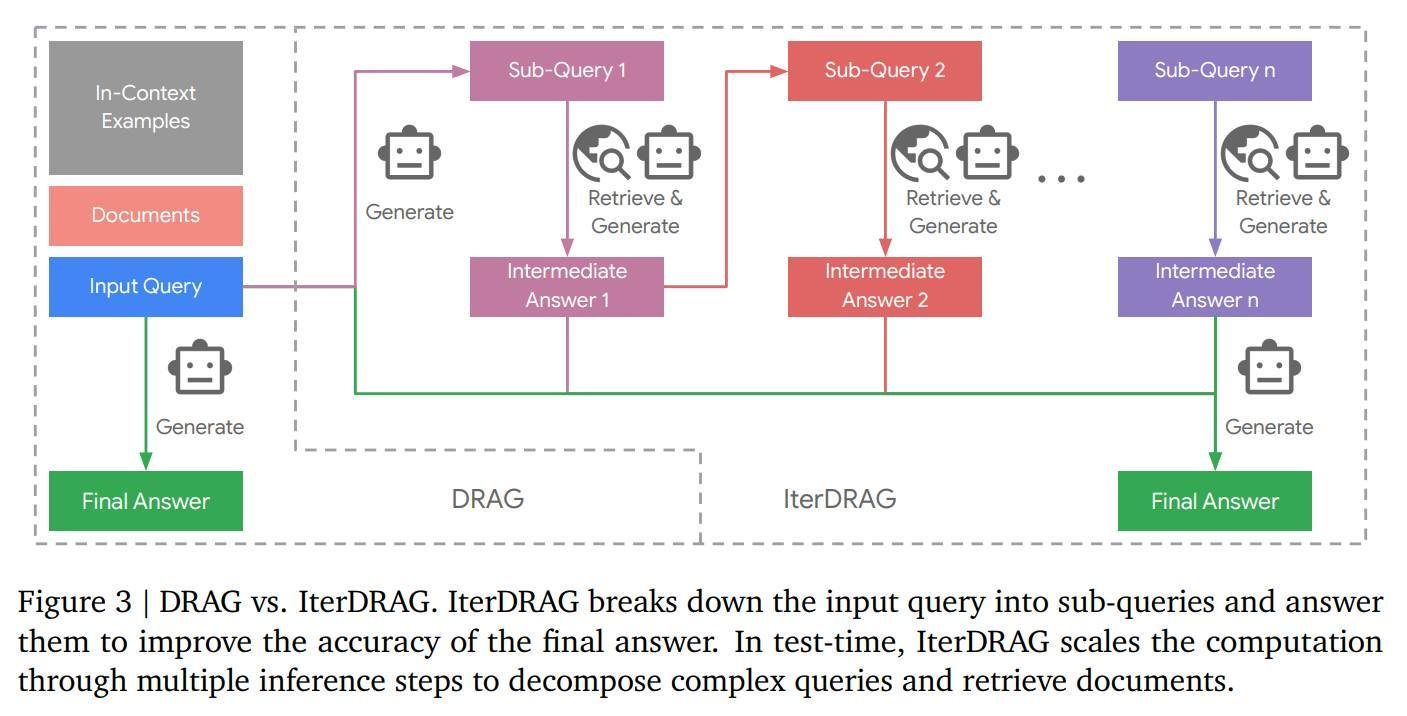
DRAG vs IterDRAG Diagram


This notebook implements two advanced inference scaling techniques from the research paper ["Inference Scaling for Long-Context Retrieval Augmented Generation"](https://arxiv.org/html/2410.04343v1):

1. **DRAG (Demonstration-based RAG)**: This method leverages in-context learning to improve RAG performance. By including multiple RAG examples as demonstrations, DRAG helps models learn to locate relevant information in long contexts. Unlike standard RAG which might plateau with more documents, DRAG shows linear improvements with increased context length.

2. **IterDRAG (Iterative Demonstration-based RAG)**: An extension of DRAG that addresses complex multi-hop queries by decomposing them into simpler sub-queries. IterDRAG interleaves retrieval and generation steps, creating reasoning chains that bridge compositional gaps. This approach is particularly effective for handling complex queries across long contexts.

These methods show that scaling inference computation can improve RAG performance almost linearly when optimally allocated, allowing RAG systems to make better use of long-context capabilities of modern LLMs.

For this implementation, we'll use an IBM Granite model capable of processing different modalities. You'll create an AI system to answer real-time user queries from unstructured data, applying the principles from the paper.

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) is a technique used with large language models (LLMs) to connect the model with a knowledge base of information outside the data the LLM has been trained on without having to perform [fine-tuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning). Traditional RAG is limited to text-based use cases such as text summarization and chatbots.

Multimodal RAG can use [multimodal](https://www.ibm.com/think/topics/multimodal-ai) LLMs (MLLM) to process information from multiple types of data to be included as part of the external knowledge base used in RAG. Multimodal data can include text, images, audio, video or other forms. In this recipe we use IBM's latest multimodal vision model, Granite 3.2 vision.

## Prerequisites

- Familiarity with Python programming.
- Basic understanding of LLMs, NLP concepts and computer vision.

## Step 1: Setting up the environment

Ensure you are running Python 3.10, 3.11 or 3.12 in a freshly created virtual environment.

In [ ]:
import sys
assert sys.version_info >= (3, 10) and sys.version_info < (3, 13), "Use Python 3.10, 3.11, or 3.12 to run this notebook."

## Step 2: Install dependencies

In [ ]:
! pip install "git+https://github.com/ibm-granite-community/utils.git" \
    transformers \
    pillow \
    langchain_community \
    langchain_huggingface \
    langchain_milvus \
    docling \
    replicate

### Logging

To see some logging information, we can configure INFO log level.

NOTE: It is okay to skip running this cell.

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)

## Step 3: Selecting the AI models

### Load the Granite models

Specify the embeddings model to use for generating text embedding vectors. Here we will use one of the [Granite Embeddings models](https://huggingface.co/collections/ibm-granite/granite-embedding-models-6750b30c802c1926a35550bb)

To use a different embeddings model, replace this code cell with one from [this Embeddings Model recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Embeddings_Models.ipynb).

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import AutoTokenizer

embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
embeddings_model = HuggingFaceEmbeddings(
    model_name=embeddings_model_path,
)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)

Specify the MLLM to use for image understanding. We will use the Granite vision model.

In [ ]:
from ibm_granite_community.notebook_utils import get_env_var
from langchain_community.llms import Replicate
from transformers import AutoProcessor

vision_model_path = "ibm-granite/granite-vision-3.2-2b"
vision_model = Replicate(
    model=vision_model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": embeddings_tokenizer.max_len_single_sentence, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
        "temperature": 0.01,
    },
)
vision_processor = AutoProcessor.from_pretrained(vision_model_path)

Specify the language model to use for the RAG generation operation. Here we use the Replicate LangChain client to connect to a Granite model from the [`ibm-granite`](https://replicate.com/ibm-granite) org on Replicate.

To get set up with Replicate, see [Getting Started with Replicate](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_Replicate.ipynb).

To connect to a model on a provider other than Replicate, substitute this code cell with one from the [LLM component recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_LLMs.ipynb).

In [ ]:
model_path = "ibm-granite/granite-3.2-8b-instruct"
model = Replicate(
    model=model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": 1000, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
        "temperature": 0.01
    },
)
tokenizer = AutoTokenizer.from_pretrained(model_path)

## Step 4: Preparing the documents for the vector database

In this example, from a set of source documents, we use [Docling](https://docling-project.github.io/docling/) to convert the documents into text and images. The text is then split into chunks. The images are processed by the MLLM to generate image summaries.

### Use Docling to download the documents and convert to text and images

Docling will download the PDF documents and process them so we can obtain the text and images the documents contain. In the PDF, there are various data types, including text, tables, graphs and images.

In [ ]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions

pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,
    generate_picture_images=True,
)
format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}
converter = DocumentConverter(format_options=format_options)

sources = [
    "https://midwestfoodbank.org/images/AR_2020_WEB2.pdf",
]
conversions = { source: converter.convert(source=source).document for source in sources }

With the documents processed, we then further process the text elements in the documents. We chunk them into appropriate sizes for the embeddings model we are using. A list of LangChain documents are created from the text chunks.

In [ ]:
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

doc_id = 0
texts: list[Document] = []
for source, docling_document in conversions.items():
    for chunk in HybridChunker(tokenizer=embeddings_tokenizer).chunk(docling_document):
        items = chunk.meta.doc_items
        if len(items) == 1 and isinstance(items[0], TableItem):
            continue # we will process tables later
        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        print(refs)
        text = chunk.text
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": refs,
            },
        )
        texts.append(document)

print(f"{len(texts)} text document chunks created")

Next we process any tables in the documents. We convert the table data to markdown format for passing into the language model. A list of LangChain documents are created from the table's markdown renderings.

In [ ]:
from docling_core.types.doc.labels import DocItemLabel

doc_id = len(texts)
tables: list[Document] = []
for source, docling_document in conversions.items():
    for table in docling_document.tables:
        if table.label in [DocItemLabel.TABLE]:
            ref = table.get_ref().cref
            print(ref)
            text = table.export_to_markdown()
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref
                },
            )
            tables.append(document)


print(f"{len(tables)} table documents created")

Finally we process any images in the documents. Here we use the vision language model to understand the content of an image. In this example, we are interested in any textual information in the image.

The choice of image prompt is critical as it directs what aspects of the image the model will focus on. For example:
- A prompt like "Give a detailed description of what is depicted in the image" (used below) will provide general information about all visual elements
- A prompt like "What text appears in this image?" would focus specifically on extracting textual content
- A prompt like "Describe the graphical data visualization in this image" would be better for charts and graphs

You should experiment with different prompts based on the types of images in your documents and what information you need to extract from them.

NOTE: Processing the images may require significant processing time depending upon the number of images and the service running the vision language model.

In [ ]:
import base64
import io
import PIL.Image
import PIL.ImageOps

def encode_image(image: PIL.Image.Image, format: str = "png") -> str:
    image = PIL.ImageOps.exif_transpose(image) or image
    image = image.convert("RGB")

    buffer = io.BytesIO()
    image.save(buffer, format)
    encoding = base64.b64encode(buffer.getvalue()).decode("utf-8")
    uri = f"data:image/{format};base64,{encoding}"
    return uri

# Feel free to experiment with this prompt
image_prompt = "Give a detailed description of what is depicted in the image"
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": image_prompt},
        ],
    },
]
vision_prompt = vision_processor.apply_chat_template(
    conversation=conversation,
    add_generation_prompt=True,
)
pictures: list[Document] = []
doc_id = len(texts) + len(tables)
for source, docling_document in conversions.items():
    for picture in docling_document.pictures:
        ref = picture.get_ref().cref
        print(ref)
        image = picture.get_image(docling_document)
        if image:
            text = vision_model.invoke(vision_prompt, image=encode_image(image))
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref,
                },
            )
            pictures.append(document)

print(f"{len(pictures)} image descriptions created")

We can then display the LangChain documents created from the input documents.

In [ ]:
import itertools
from docling_core.types.doc.document import RefItem
from IPython.display import display

# Print all created documents
for document in itertools.chain(texts, tables):
    print(f"Document ID: {document.metadata['doc_id']}")
    print(f"Source: {document.metadata['source']}")
    print(f"Content:\n{document.page_content}")
    print("=" * 80)  # Separator for clarity

for document in pictures:
    print(f"Document ID: {document.metadata['doc_id']}")
    source = document.metadata['source']
    print(f"Source: {source}")
    print(f"Content:\n{document.page_content}")
    docling_document = conversions[source]
    ref = document.metadata['ref']
    picture = RefItem(cref=ref).resolve(docling_document)
    image = picture.get_image(docling_document)
    print("Image:")
    display(image)
    print("=" * 80)  # Separator for clarity


## Populate the vector database

Using the embedding model, we load the documents from the text chunks and generated image captioning into a vector database. Creating this vector database allows us to easily conduct a semantic similarity search across our documents.

NOTE: Population of the vector database may require significant processing time depending on your embedding model and service.

### Choose your vector database

Specify the database to use for storing and retrieving embedding vectors.

To connect to a vector database other than Milvus, replace this code cell with one from [this Vector Store recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Vector_Stores.ipynb).

In [ ]:
import tempfile
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus

db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"The vector database will be saved to {db_file}")

vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,
    index_params={"index_type": "AUTOINDEX"},
)

We now add all the LangChain documents for the text, tables and image descriptions to the vector database.

In [ ]:
import itertools

documents = list(itertools.chain(texts, tables, pictures))
ids = vector_db.add_documents(documents)
print(f"{len(ids)} documents added to the vector database")

## Step 5: RAG with Granite

Now that we have successfully converted our documents and vectorized them, we can set up our RAG pipeline.

### Validate Retrieval Quality

Here we test the vector database by searching for chunks with relevant information to our query in the vector space. We display the documents associated with the retrieved image description.

This validation step is important to ensure that our retrieval system is working correctly before we build our full RAG pipeline. We want to see if the returned documents are actually relevant to our query.

Feel free to try different queries.

In [ ]:
query = "Analyze how Midwest Food Bank's financial efficiency changed during the pandemic by comparing their 2019 and 2020 performance metrics. What specific pandemic adaptations had the greatest impact on their operational capacity, and how did their volunteer management strategy evolve to maintain service levels despite COVID-19 restrictions? Provide specific statistics from the report to support your analysis."
for doc in vector_db.as_retriever(search_kwargs={"k": 10}).invoke(query):
    print(doc)
    print("=" * 80)  # Separator for clarity

The returned document should be responsive to the query. Let's go ahead and construct our RAG pipeline.

### Create the RAG pipeline for Granite

First we create the prompts for Granite to perform the RAG query. We use the Granite chat template and supply the placeholder values that the LangChain RAG pipeline will replace.

`{context}` will hold the retrieved chunks, as shown in the previous search, and feeds this to the model as document context for answering our question.

Next, we construct the RAG pipeline by using the Granite prompt templates previously created.


In [ ]:
from langchain.prompts import PromptTemplate
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# Create a Granite prompt for question-answering with the retrieved context
prompt = tokenizer.apply_chat_template(
    conversation=[{
        "role": "user",
        "content": "{input}",
    }],
    documents=[{
        "text": "{context}",
    }],
    add_generation_prompt=True,
    tokenize=False,
)
prompt_template = PromptTemplate.from_template(template=prompt)

# Create a Granite document prompt template to wrap each retrieved document
document_prompt_template = PromptTemplate.from_template(template="""\
Document {doc_id}
{page_content}""")
document_separator="\n\n"

# Assemble the retrieval-augmented generation chain
combine_docs_chain = create_stuff_documents_chain(
    llm=model,
    prompt=prompt_template,
    document_prompt=document_prompt_template,
    document_separator=document_separator,
)
rag_chain = create_retrieval_chain(
    retriever=vector_db.as_retriever(search_kwargs={"k": 10}),
    combine_docs_chain=combine_docs_chain,
)

### Generate a retrieval-augmented response to a question

The pipeline uses the query to locate documents from the vector database and use them as context for the query.

In [ ]:
outputs = rag_chain.invoke({"input": query})
print(prompt)
print(outputs['answer'])

## Standard RAG Limitations and Why We Need Inference Scaling

While the standard RAG approach works reasonably well, it has several key limitations when dealing with long or complex content:

1. **Context Management**: When dealing with many documents, standard RAG struggles to effectively utilize all the available context.
2. **Retrieval Quality**: Without guidance on how to use the retrieved information, models often focus on the wrong parts of documents.
3. **Compositional Reasoning**: Complex queries requiring multi-step reasoning are challenging for standard RAG.
4. **Performance Plateaus**: Adding more documents to standard RAG often results in diminishing returns after a certain threshold.

Inference scaling techniques address these limitations by strategically allocating more computation at test time.

## Enhanced RAG with DRAG (Demonstration-based RAG)

Now we'll implement the DRAG technique from the research paper ["Inference Scaling for Long-Context Retrieval Augmented Generation"](https://arxiv.org/html/2410.04343v1) to enhance our RAG system.

DRAG uses in-context examples to demonstrate to the model how to extract and use information from documents, improving performance for long-context scenarios.

### Step 1: Create sample in-context demonstrations
These would typically come from a curated dataset of high-quality QA pairs.
For this example, we'll create some synthetic examples that match the expected domain

In [ ]:
import random
from langchain_core.documents import Document

def create_enhanced_drag_demonstrations(vector_db, num_examples=3, k_docs_per_example=5):
    """Create high-quality demonstrations for DRAG technique that showcase effective document analysis"""

    example_queries = [
        "How did the COVID-19 pandemic impact Midwest Food Bank's operations in 2020?",
        "What role did volunteers play at Midwest Food Bank during 2020, and how were they affected by the pandemic?",
        "How did Midwest Food Bank's international programs perform during 2020, particularly in Haiti and East Africa?"
    ]

    example_answers = [
        "The COVID-19 pandemic significantly impacted Midwest Food Bank's operations in 2020. Despite challenges, MFB remained open and responsive to increased needs. They implemented safety protocols, reduced volunteer numbers for social distancing, and altered their distribution model to allow partner agencies to receive food safely. The pandemic created unprecedented food insecurity, with many people seeking assistance for the first time. MFB distributed 37% more food than in 2019, with a record 179 semi-loads of Disaster Relief family food boxes sent nationwide. The organization also faced supply chain disruptions and food procurement challenges in the early months but continued to find and distribute food. Community, business, and donor support helped fund operations and food purchases. Additionally, MFB began participating in the USDA Farmers to Families Food Box program in May 2020, distributing over $52 million worth of nutritious produce, protein, and dairy products.",

        "Volunteers were described as 'the life-blood of the organization' in the 2020 annual report. Despite the pandemic creating safety challenges, volunteers demonstrated courage and dedication by increasing their hours to meet growing needs. MFB implemented safety protocols at each location and limited volunteer group sizes to allow for social distancing. This created a challenge as food needs increased while fewer volunteers were available to help. To address this gap, multiple MFB locations received assistance from the National Guard, who filled vital volunteer positions driving trucks, operating forklifts, and helping with food distributions. In 2020, 17,930 individuals volunteered 300,898 hours of service, equivalent to 150 full-time employees. The volunteer-to-staff ratio was remarkable with 450 volunteers for every 1 paid MFB staff member, highlighting the volunteer-driven nature of the organization during the crisis.",

        "In 2020, Midwest Food Bank's international operations in East Africa and Haiti faced unique challenges but continued to serve communities. In East Africa (operated as Kapu Africa), strict lockdowns led to mass hunger, especially in slum areas. Kapu Africa distributed 7.2 million Tender Mercies meals, working with partner ministries to share food in food-insecure slums. A notable outcome was a spiritual awakening among recipients, with many asking why they were receiving help. In Haiti, the pandemic added to existing challenges, closing airports, seaports, factories, and schools. MFB Haiti more than doubled its food shipments to Haiti, delivering over 160 tons of food relief, nearly three-quarters being Tender Mercies meals. As Haitian children primarily receive nourishment from school lunches, MFB Haiti distributed Tender Mercies through faith-based schools and also partnered with over 20 feeding centers serving approximately 1,100 children daily. Nearly 1 million Tender Mercies meals were distributed in Haiti during 2020."
    ]

    demonstrations = []
    for i in range(min(num_examples, len(example_queries))):
        # For each example, retrieve relevant documents
        retrieved_docs = vector_db.as_retriever(search_kwargs={"k": k_docs_per_example}).invoke(example_queries[i])

        # Create a demonstration example
        demonstration = {
            "query": example_queries[i],
            "documents": retrieved_docs,
            "answer": example_answers[i]
        }
        demonstrations.append(demonstration)

    return demonstrations

### Step 2: Format the demonstrations for inclusion in the prompt


In [ ]:
def format_demonstration(demo, document_prompt_template, document_separator):
    """Format a single demonstration for inclusion in the prompt"""
    # Format documents for this demonstration
    formatted_docs = []
    for i, doc in enumerate(demo["documents"]):
        # Apply document prompt template to each document
        formatted_doc = document_prompt_template.format(
            doc_id=f"example-{i+1}",
            page_content=doc.page_content
        )
        formatted_docs.append(formatted_doc)

    # Join documents with separator
    context = document_separator.join(formatted_docs)

    # Format the full demonstration
    return f"""
Example:
Question: {demo["query"]}
Context:
{context}
Answer: {demo["answer"]}
"""

### Step 3: Create demonstrations for DRAG


In [ ]:
num_demonstrations = 3  # You can adjust this value
docs_per_demonstration = 5  # Number of documents per demonstration example
demonstrations = create_enhanced_drag_demonstrations(vector_db, num_demonstrations, docs_per_demonstration)

# Format all demonstrations together
formatted_demonstrations = "\n\n".join([
    format_demonstration(demo, document_prompt_template, document_separator)
    for demo in demonstrations
])

### Step 4: Create the DRAG prompt template



In [ ]:
drag_prompt = tokenizer.apply_chat_template(
    conversation=[{
        "role": "system",
        "content": f"""You are Granite, developed by IBM. Write the response to the user's input by strictly aligning with the facts in the provided documents.
        If the information needed to answer the question is not available in the documents, inform the user that the question cannot be answered based on the available data.
        Here are examples of effectively extracting information from documents to answer questions:

        {formatted_demonstrations}

        Follow these examples when answering the user's question."""
    }, {
        "role": "user",
        "content": "{input}",
    }],
    documents=[{
        "text": "{context}",
    }],
    add_generation_prompt=True,
    tokenize=False,
)

# Convert to prompt template
drag_prompt_template = PromptTemplate.from_template(template=drag_prompt)

### Step 5: Create a custom retriever that reorders documents (higher ranked closer to query)


In [ ]:
class ReorderingRetriever:
    def __init__(self, base_retriever):
        self.base_retriever = base_retriever

    def invoke(self, query):
        docs = self.base_retriever.invoke(query)
        return list(reversed(docs))  # Reverse the order so higher-ranked docs are closer to query

# Create the base retriever with increased document count
base_retriever = vector_db.as_retriever(search_kwargs={"k": 10})  # Retrieve more documents
reordering_retriever = ReorderingRetriever(base_retriever)

### Step 6: Create DRAG pipeline


In [ ]:
drag_combine_docs_chain = create_stuff_documents_chain(
    llm=model,
    prompt=drag_prompt_template,
    document_prompt=document_prompt_template,
    document_separator=document_separator,
)

drag_chain = create_retrieval_chain(
    retriever=vector_db.as_retriever(search_kwargs={"k": 10}),
    combine_docs_chain=drag_combine_docs_chain,
)

### Step 7: Generate a DRAG-enhanced response to a question

In [ ]:
drag_outputs = drag_chain.invoke({"input": query})
print("\n=== DRAG-Enhanced Answer ===")
print(drag_outputs['answer'])

Great, looks like we got some improvements in the answer by giving it some examples. Let's try an even more thorough RAG technique next!

## Implementing IterDRAG (Iterative Demonstration-based RAG)

IterDRAG extends DRAG by decomposing complex queries into simpler sub-queries and performing interleaved retrieval. This is particularly effective for complex multi-hop questions that require integrating information from multiple sources or reasoning across several steps.

Key benefits of the iterative approach:
- Breaks down complex questions into manageable pieces
- Retrieves more relevant information for each sub-question
- Creates explicit reasoning chains
- Enables tackling questions that would be challenging in a single step


In [ ]:
from langchain.chains import LLMChain
import re

### Step 1: Create a query decomposition chain

The decomposition step is critical - it takes a complex query and breaks it into simpler, more focused sub-queries that can be answered individually.

In [ ]:
decompose_prompt = tokenizer.apply_chat_template(
    conversation=[{
        "role": "system",
        "content": """You are a helpful assistant that breaks down complex questions into simpler sub-questions.
        For multi-part or complex questions, generate 1-3 sub-questions that would help answer the main question."""
    }, {
        "role": "user",
        "content": """Please break down the following question into simpler sub-questions. Format your response as:
        Follow up: [sub-question]

        If the question is simple enough already, just respond with "No follow-up needed."

        Question: {question}"""
    }],
    add_generation_prompt=True,
    tokenize=False,
)

decompose_prompt_template = PromptTemplate.from_template(template=decompose_prompt)
decompose_chain = LLMChain(llm=model, prompt=decompose_prompt_template)

### Step 2: Create a sub-query answering chain

The sub-query answering component handles each individual sub-question by retrieving relevant documents and generating focused intermediate answers.


In [ ]:
sub_answer_prompt = tokenizer.apply_chat_template(
    conversation=[{
        "role": "system",
        "content": """You are a helpful assistant that answers specific questions based on the provided context.
        Focus only on the sub-question and provide a concise intermediate answer."""
    }, {
        "role": "user",
        "content": """Please answer the following sub-question based on the provided context.
        Format your response as:
        Intermediate answer: [your concise answer to the sub-question]

        Sub-question: {sub_question}

        Context:
        {context}"""
    }],
    documents=[{
        "Context": "{context}",
    }],
    add_generation_prompt=True,
    tokenize=False,
)

sub_answer_prompt_template = PromptTemplate.from_template(template=sub_answer_prompt)
sub_answer_chain = create_stuff_documents_chain(
    llm=model,
    prompt=sub_answer_prompt_template,
    document_prompt=document_prompt_template,
    document_separator=document_separator,
)

### Step 3: Create a final answer generation chain

The final answer generation component combines all the intermediate answers to produce a comprehensive response to the original question.

In [ ]:
final_answer_prompt = tokenizer.apply_chat_template(
    conversation=[{
        "role": "system",
        "content": """You are a helpful assistant that provides comprehensive answers to questions.
        Use the intermediate answers to sub-questions to formulate a complete final answer."""
    }, {
        "role": "user",
        "content": """Please provide a final answer to the main question based on the intermediate answers to sub-questions.
        Format your response as:
        So the final answer is: [your comprehensive answer to the main question]

        Main question: {main_question}

        Sub-questions and intermediate answers:
        {sub_qa_pairs}"""
    }],
    add_generation_prompt=True,
    tokenize=False,
)

final_answer_prompt_template = PromptTemplate.from_template(template=final_answer_prompt)
final_answer_chain = LLMChain(llm=model, prompt=final_answer_prompt_template)

### Step 4: Create example demonstrations for IterDRAG

Creating effective demonstrations is crucial for IterDRAG's performance. These examples show the model how to:
1. Break down complex questions into simpler sub-questions
2. Generate relevant intermediate answers
3. Combine these answers into a coherent final response


In [ ]:
def create_iterdrag_demonstrations(num_examples=2):
    """Create examples showing how to decompose and answer complex questions"""

    demonstrations = [
        {
            "main_question": "What impact did the pandemic have on the food bank's operations and distribution?",
            "sub_questions": [
                "How did food distribution volume change during the pandemic?",
                "What operational challenges did the food bank face during the pandemic?",
                "What new programs were implemented in response to the pandemic?"
            ],
            "intermediate_answers": [
                "Food distribution volume increased by 60% during the pandemic, rising from approximately 62 million pounds in 2019 to over 100 million pounds in 2020.",
                "The food bank faced challenges including supply chain disruptions, volunteer shortages due to social distancing requirements, and the need to implement new safety protocols for food handling and distribution.",
                "New programs included contactless distribution methods, expanded mobile pantry operations, emergency food boxes for vulnerable populations, and virtual nutrition education classes."
            ],
            "final_answer": "The pandemic had a profound impact on food bank operations and distribution. Distribution volume increased by 60% to over 100 million pounds of food in 2020. Operationally, the food bank faced supply chain disruptions, volunteer shortages, and safety protocol challenges. In response, they implemented contactless distribution, expanded mobile pantries, created emergency food boxes for vulnerable populations, and developed virtual nutrition education. Despite these challenges, they successfully scaled operations to meet the unprecedented community need during the crisis."
        },
        {
            "main_question": "How does the food bank's financial management compare to industry standards for non-profits?",
            "sub_questions": [
                "What percentage of the food bank's budget goes to program services versus administrative costs?",
                "What are the industry standards for program spending versus overhead for food banks?"
            ],
            "intermediate_answers": [
                "94% of the food bank's budget goes directly to program services, with only 6% allocated to administrative and fundraising costs.",
                "Industry standards suggest that well-run food banks typically allocate 85-90% of their budget to program services, with 10-15% for administrative and fundraising expenses."
            ],
            "final_answer": "The food bank demonstrates excellent financial management compared to industry standards. With 94% of its budget allocated to program services and only 6% to administrative and fundraising costs, it exceeds the industry benchmark of 85-90% for program spending. This financial efficiency places the food bank among the top-performing non-profits in terms of maximizing donor impact and minimizing overhead expenses."
        }
    ]

    # Format demonstrations for the prompt
    formatted_demos = ""
    for demo in demonstrations[:num_examples]:
        formatted_demo = f"""
        Example:
        Main question: {demo['main_question']}

        Step 1: Decompose into sub-questions
        """
        for i, sq in enumerate(demo['sub_questions']):
            formatted_demo += f"Follow up: {sq}\n"

        formatted_demo += "\nStep 2: Answer each sub-question\n"
        for i, (sq, ans) in enumerate(zip(demo['sub_questions'], demo['intermediate_answers'])):
            formatted_demo += f"Sub-question: {sq}\nIntermediate answer: {ans}\n\n"

        formatted_demo += f"Step 3: Generate final answer\nSo the final answer is: {demo['final_answer']}"
        formatted_demos += formatted_demo + "\n\n"

    return formatted_demos

# Add demonstrations to decompose prompt
iterdrag_demonstrations = create_iterdrag_demonstrations()
decompose_prompt_with_demos = tokenizer.apply_chat_template(
    conversation=[{
        "role": "system",
        "content": f"""

        You are a helpful assistant that breaks down complex questions into simpler sub-questions.
        For multi-part or complex questions, generate 1-3 sub-questions that would help answer the main question.

        Here are examples of how to decompose complex questions:
        {iterdrag_demonstrations}

        Follow these examples when breaking down the user's question."""
    }, {
        "role": "user",
        "content": f"""

        Please break down the following question into simpler sub-questions. Format your response as:
        Follow up: [sub-question]

        If the question is simple enough already, just respond with "No follow-up needed."

        Question: {{question}}"""
    }],
    add_generation_prompt=True,
    tokenize=False,
)

decompose_prompt_template = PromptTemplate.from_template(template=decompose_prompt_with_demos)
decompose_chain = LLMChain(llm=model, prompt=decompose_prompt_template)

### Step 5: Implement the IterDRAG function

This function orchestrates the entire iterative process:
1. Decompose the main question into sub-questions
2. For each sub-question, retrieve relevant documents and generate an intermediate answer
3. Combine all intermediate answers to produce the final response

In [ ]:
def iterative_drag(query, vector_db, max_iterations=3):
    """
    Implements IterDRAG: decomposing queries, retrieving documents for sub-queries,
    and generating a final answer based on intermediate answers.
    """
    print(f"\n=== Processing query with IterDRAG: '{query}' ===")

    # Store the main question
    main_question = query

    # Step 1: Decompose the main question into sub-questions
    print("Step 1: Decomposing the query into sub-questions...")
    decompose_result = decompose_chain.invoke({"question": main_question})
    decompose_output = decompose_result["text"]

    # Check if no decomposition is needed
    if "No follow-up needed" in decompose_output:
        print("No decomposition needed. Using standard DRAG approach.")
        return drag_chain.invoke({"input": main_question})

    # Extract sub-questions using regex
    sub_questions = re.findall(r"Follow up: (.*?)(?=Follow up:|$)", decompose_output, re.DOTALL)
    sub_questions = [sq.strip() for sq in sub_questions if sq.strip()]

    if not sub_questions:
        print("Could not extract sub-questions. Using standard DRAG approach.")
        return drag_chain.invoke({"input": main_question})

    print(f"Decomposed into {len(sub_questions)} sub-questions:")
    for i, sq in enumerate(sub_questions):
        print(f"  {i+1}. {sq}")

    # Step 2: Answer each sub-question
    sub_qa_pairs = []
    for i, sub_question in enumerate(sub_questions[:max_iterations]):
        print(f"\nStep 2.{i+1}: Processing sub-question: {sub_question}")

        # Retrieve documents relevant to this sub-question
        retrieved_docs = reordering_retriever.invoke(sub_question)
        print(f"Retrieved {len(retrieved_docs)} documents for this sub-question")

        # Generate answer for this sub-question
        sub_answer_result = sub_answer_chain.invoke({
            "sub_question": sub_question,
            "context": retrieved_docs
        })

        # Extract intermediate answer using regex
        intermediate_answer_match = re.search(r"Intermediate answer: (.*?)$", sub_answer_result, re.DOTALL)
        if intermediate_answer_match:
            intermediate_answer = intermediate_answer_match.group(1).strip()
        else:
            intermediate_answer = sub_answer_result

        print(f"Generated intermediate answer: {intermediate_answer[:100]}...")

        # Store the sub-question and its answer
        sub_qa_pairs.append({
            "sub_question": sub_question,
            "intermediate_answer": intermediate_answer
        })

    # Step 3: Generate the final answer based on sub-question answers
    print("\nStep 3: Generating final answer based on intermediate answers...")
    sub_qa_formatted = "\n\n".join([
        f"Sub-question: {pair['sub_question']}\nIntermediate answer: {pair['intermediate_answer']}"
        for pair in sub_qa_pairs
    ])

    final_answer_result = final_answer_chain.invoke({
        "main_question": main_question,
        "sub_qa_pairs": sub_qa_formatted
    })

    # Extract final answer
    final_answer_match = re.search(r"So the final answer is: (.*?)$", final_answer_result["text"], re.DOTALL)
    if final_answer_match:
        final_answer = final_answer_match.group(1).strip()
    else:
        final_answer = final_answer_result["text"]

    return {"answer": final_answer, "sub_qa_pairs": sub_qa_pairs}

## Comparing RAG Approaches

Now that we have all three RAG approaches set up, let's compare there responses same query, this time much more complex, to see the differences.

The comparison will help us understand the benefits of each approach and when each might be most appropriate to use.

In [ ]:
# Run all approaches on the same complex query
comparison_query = "What was the full impact chain of the National Guard's assistance during the pandemic? Specifically, how did their involvement affect volunteer operations, what specific tasks did they perform, and how did this ultimately translate to community impact in terms of food distribution capabilities and reach?"

print("\n=== Standard RAG ===")
standard_result = rag_chain.invoke({"input": comparison_query})
print(standard_result["answer"])

print("\n=== DRAG ===")
drag_result = drag_chain.invoke({"input": comparison_query})
print(drag_result["answer"])

print("\n=== IterDRAG ===")
iterdrag_result = iterative_drag(comparison_query, vector_db)
print(iterdrag_result["answer"])

## Results Comparison and Analysis

Here we summarize the performance differences between the three RAG approaches implemented:

| Approach | Strengths | Limitations | Best Use Cases |
|----------|-----------|-------------|----------------|
| Standard RAG | - Simple implementation<br>- Good for straightforward queries<br>- Lower computational requirements | - Limited context utilization<br>- Performance plateaus with more documents<br>- Poor at complex reasoning | - Simple factual queries<br>- When computation is limited<br>- When context is small |
| DRAG | - Better context utilization<br>- Improved performance with more documents<br>- Good for moderately complex queries | - Still limited by one-step generation<br>- Less effective for multi-hop questions | - Moderate complexity queries<br>- When more documents are available<br>- When in-context examples can be provided |
| IterDRAG | - Best for complex queries<br>- Explicit reasoning chains<br>- Most effective use of context | - Highest computational requirements<br>- More complex implementation | - Multi-hop questions<br>- Complex analyses requiring composite reasoning<br>- When maximum performance is needed |

As we've seen in our implementation, inference scaling techniques like DRAG and IterDRAG can significantly improve RAG performance, especially for complex queries requiring deep analysis of multiple documents.

## Conclusion and Next Steps

In this tutorial, we've explored how inference scaling can dramatically improve RAG performance. By strategically allocating additional computation at test time through techniques like DRAG and IterDRAG, we can achieve substantial gains in response quality for complex queries.

Key takeaways:
- Inference scaling provides almost linear improvements in RAG performance when optimally configured
- DRAG enhances standard RAG by using in-context examples to guide information extraction
- IterDRAG further improves performance through query decomposition and interleaved retrieval
- These approaches are particularly valuable for complex, multi-hop questions

Next steps you might consider:
- Experiment with different retrieval models and document preprocessing approaches
- Try different prompt formulations for image understanding
- Explore parameter optimization to find the ideal settings for your specific use case

By applying these inference scaling techniques to your RAG applications, you can achieve significantly better performance on knowledge-intensive tasks without changing your underlying models.